# intro
This notebook demonstrate solving forward and inverse problem using tree-based machine learning models, applied to spectral emissivity of particles.

![image](images\forward_inverse_demo.png)


# Step #0: Importing
make sure you install these packages before running.

In [1]:
# misc
import json
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import warnings
import sys
import os
from time import strftime, time
from math import pi

# saving and loading data
import joblib
import glob
import pickle

# data processing
import numpy as np
import pandas as pd
import scipy
from scipy.io import loadmat

# ML tools, sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# to ignore warnings displayed in notebook
warnings.filterwarnings('ignore')

# setting plotting parameters
import matplotlib.pyplot as plt
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)             # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)        # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)       # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)      # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)      # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)       # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)     # fontsize of the figure title
plt.rcParams["font.family"] = "Helvetica"       # fontname

# for unit conversion
from astropy import units as u

# homemade
from forward_utils import load_spectrum_param_data_mat, calc_RMSE_MAE_MSE_Erel, z_RF_DT_DTGEN_error_folds, spectra_prediction_corrector, feature_importance_by_material, get_iloc_for_test_on_edges_of_column, error_integ_by_spectrum_integ, plt2matlab,get_all_children, get_confidence_interval_for_random_forest, gen_data_P1_P2_P3_Elzouka

from inverse_utils import \
    DoInverseDesign_SaveCSV, \
    draw_target_spectrum_from_low_high_ranges, \
    plot_spectral_target_VS_spectral_predicted_using_InverseDesignFeatures
 
from forward_utils import df_to_csv, feature_importance_by_material

C:\Users\mahmo\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Step #1: Setting inputs and parameters

In [2]:
n_estimators = 200 # number of estimators (i.e., individual decision trees) used to build the random forest

test_size = 0.8 # fraction of the data that is used for testing the ML model.

n_cpus = 1 # optional, if you would like sklearn to use more than 1 CPU in the training.

num_folds_training_for_errors = 2  # when we assess the performance of ML model, we estimate the error of ML in predicting the output, by comparing the output of the ML against the test data. Because error in ML prediction have variance, we need to build ML model multiple times, and take the average of the prediction error. "num_folds_training_for_errors" is the nummber of times we build independent ML models and assess their prediction error, and take the average of this prediction error.
# this is only required if you would like to see the performance of your ML model when changing any of the its training parameters (e.g., size of training data, number of estimators, etc.)

n_gen_to_data_ratio = 5  # 180 has worked fine for me.
# the ratio between n_gen (i.e., datasize that will be used to train DTGEN) to the data used for training the ML (either DT or RF).

## imputs if we need to reduce the size of our data.
# Ideally, you would like to use all the data you have, but here, we were trying to see what is the minimum size of data required to build a reliable ML
# the fraction of original data to be used for ML.
train_datasize_fraction_scalar = 0.5
# the fraction of original data to be used for ML.
train_datasize_fraction_spectral = 0.5

# number of datapoints for each geometry class
n_data_desired = {
    'Geometry_sphere': 500,
    'Geometry_wire': 800,
    'Geometry_parallelepiped': 2000,
    'Geometry_TriangPrismIsosc': 2000,
}

# True: use log emissivity as input to ML, this will make the training target to minimize relative error (i.e., MINIMIZE( log(y_pred) - log(y_test) ) is equivalent to MINIMIZE( log(y_pred / y_test) ))
use_log_emissivity = True

## inputs to study the impact of datasize on ML performance
Study_performance_VS_datasize = False # se to True if you would like to do this study.
data_size_fraction_ = np.array(
    [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)
data_size_fraction_ = np.array([0.5])
#data_size_fraction_ = np.array([0.01,0.02,0.05])

Models_to_Study_performanceVSsize = ['DTGEN', 'DT']
Models_to_Study_performanceVSsize = ['RF']

num_folds_repeat_DataReduction = 1

# list that contains either 'scalar' or 'spectral' or both
spectral_or_scalar_calc_all = ['scalar', 'spectral']


datetime_str = strftime("%Y%m%d_%H%M%S")

matlab_data_path = ['../data/All_data_part_1.mat', '../data/All_data_part_2.mat'] # WARNING: this data has more "sphere" results

optional_title_folders = '{0}sc_{1}sp_{2}_CPU'.format(
    train_datasize_fraction_scalar*100, train_datasize_fraction_spectral*100, n_cpus)
# optional_title_folders='DataSize_study_BigTest'

#feature_set = ['Geometry_TriangPrismIsosc', 'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire',
#               'Material_Au', 'Material_SiN', 'Material_SiO2',
#               'log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim']

feature_set = ['Geometry_TriangPrismIsosc', 'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire',
              'Material_Au', 'Material_SiN', 'Material_SiO2',
              'log Area/Vol', 'log ShortestDim', 'log MiddleDim', 'log LongDim']

# DON'T CHANGE THESE VARIABLES
my_x = np.logspace(13, 14.9, num=400)
scaling_factors = {'Area': 10.0**12, 'Volume': 10.0**18, 'Volume/Area': 10.0**9, 'Area/Volume': 10.0**-6, 'LongestDim': 10.0**6, 'MiddleDim': 10.0 **
                   6, 'ShortestDim': 10.0**6, 'PeakFrequency': 10.0**-14, 'PeakEmissivity': 10.0, 'LengthX': 10**6, 'Height': 10**6, 'Length': 10**6}


# Step #2: Loading the data
The data is stored as a matlab structure *.mat files. The data is split in two files to fit the size limit of a single file on github.

In [3]:
data_featurized, interpolated_ys, spectrum_parameters = load_spectrum_param_data_mat(matlab_data_path, my_x, scaling_factors)  

Number of Samples: 33953
Removed 0 non-physical spectra
New Shape: (33953, 31)
Removed 820 Incomplete Spectra
New Shape: (33133, 31)
Removed 0 duplicates
New shape: (33133, 31)


# Step #4: Data pre-processing 

In [4]:
# separating material and geometry features, for stratifying the data
feature_set_geom = [x for x in feature_set if 'Geometry' in x]
feature_set_mat = [x for x in feature_set if 'Material' in x]
feature_set_geom_mat = feature_set_geom + feature_set_mat
feature_set_dimensions = list(set(feature_set) - set(feature_set_geom_mat))

print("dataset size, original: {0}".format(len(data_featurized)))

# drop data with A/V outside the range
sclae_here = scaling_factors['Area/Volume']
idx_low = data_featurized['Area/Vol'].values < 0.9e6*sclae_here
idx_high = data_featurized['Area/Vol'].values > 1e8*sclae_here
idx_outrange = ~np.logical_or(idx_low, idx_high)
data_featurized = data_featurized[idx_outrange]
interpolated_ys = interpolated_ys[idx_outrange]
print(
    "after dropping A/V outside range, we have {0} datapoints".format(len(data_featurized)))

# drop analytical (except spheres) samples from training
idx_num = ~data_featurized['is_analytical'].astype(bool)
idx_anal = ~idx_num
print("we have {0} numerical simulations, and {1} analytical".format(
    sum(idx_num), sum(idx_anal)))

idx_sphere = data_featurized['Geometry_sphere'].astype(bool)
print("we have {0} spheres".format(sum(idx_sphere)))

# we will keep all numerical simulations or sphere simulations
idx = np.logical_or(idx_num.values, idx_sphere.values)
print("we have {0} spheres | numerical simulation".format(sum(idx)))
data_featurized = data_featurized[idx]
interpolated_ys = interpolated_ys[idx]


# to reduce the number of datapoints for each geometry
#idx_to_keep = []
idx_to_keep = np.array([])
for geom in feature_set_geom:
    n_data_desired_here = n_data_desired[geom]
    idx_geom_here = data_featurized[geom]
    for mat in feature_set_mat:
        idx_mat_here = data_featurized[mat]
        #idx_geom_mat_here = np.logical_and(idx_geom_here.values, idx_mat_here.values)
        idx_geom_mat_here = np.where((data_featurized[geom].values == 1) & (
            data_featurized[mat].values == 1))[0]
        if n_data_desired_here >= len(idx_geom_mat_here):
            # idx_to_keep.append(idx_geom_mat_here)
            idx_to_keep = np.append(idx_to_keep, idx_geom_mat_here)
        else:
            #idx_to_keep.append(np.random.choice(idx_geom_mat_here, size=n_data_desired_here, replace=False) )
            idx_to_keep = np.append(idx_to_keep, np.random.choice(
                idx_geom_mat_here, size=n_data_desired_here, replace=False))


data_featurized = data_featurized.iloc[idx_to_keep]
interpolated_ys = interpolated_ys[idx_to_keep.astype(int)]

assert len(interpolated_ys) == len(data_featurized)

data_featurized = data_featurized.drop('is_analytical', axis=1)

print("dataset size, after dropping: {0}".format(len(data_featurized)))



dataset size, original: 33133
after dropping A/V outside range, we have 30717 datapoints
we have 29162 numerical simulations, and 1555 analytical
we have 1225 spheres
we have 30386 spheres | numerical simulation
dataset size, after dropping: 15625


# Step #5: The forward problem. Creating DT, RF and DTGEN ML models

Analyzing the error for RF, running training for 0th time out of 2 times ==========
Analyzing the error for RF, running training for 1th time out of 2 times ==========
['log Area/Vol', 'log MiddleDim', 'log LongDim', 'log ShortestDim']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

average runtime per sample on lawrencium (clock seconds): 3479.838170369834
Average runtime per sample for RF training feature(CPU seconds): 0.0007253123806857233
Average runtime per sample for RF inference feature prediction(CPU seconds): 4.480323916007657e-05
Analyzing the error for DT, running training for 0th time out of 2 times ==========
Analyzing the error for DT, running training for 1th time out of 2 times ==========
['log Area/Vol', 'log MiddleDim', 'log LongDim', 'log ShortestDim']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

average runtime per sample on lawrencium (clock seconds): 3479.838170369834
Average runtime per sample for DT training feature(CPU seconds): 7.4072276026056285e-06
Average runtime per sample for DT inference feature prediction(CPU seconds): 6.377307916746453e-07
Features used: Index(['Geometry_TriangPrismIsosc', 'Geometry_parallelepiped',
       'Geometry_sphere', 'Geometry_wire', 'Material_Au', 'Material_SiN',
       'Material_SiO2', 'log Area/Vol', 'log ShortestDim', 'log MiddleDim',
       'log LongDim'],
      dtype='object')
We have 7812 training and 7813 test samples here

RF inference, scalar =========================================================
RF error analysis
R2: 0.99152353
MAE: 0.00928381
MSE: 0.00323179
Erel: 0.03843327

DT inference, scalar =========================================================
DT error analysis
R2: 0.98150960
MAE: 0.01390016
MSE: 0.00704976
Erel: 0.06240188

DT GEN inference, scalar =====================================================
Total Time 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

average runtime per sample on lawrencium (clock seconds): 3479.838170369834
Average runtime per sample for RF training feature(CPU seconds): 0.025911360124533322
Average runtime per sample for RF inference feature prediction(CPU seconds): 0.002139023304534877
Analyzing the error for DT, running training for 0th time out of 2 times ==========
Analyzing the error for DT, running training for 1th time out of 2 times ==========
['log Area/Vol', 'log MiddleDim', 'log LongDim', 'log ShortestDim']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

average runtime per sample on lawrencium (clock seconds): 3479.838170369834
Average runtime per sample for DT training feature(CPU seconds): 0.0002465248260507813
Average runtime per sample for DT inference feature prediction(CPU seconds): 7.2760388501151545e-06
Features used: Index(['Geometry_TriangPrismIsosc', 'Geometry_parallelepiped',
       'Geometry_sphere', 'Geometry_wire', 'Material_Au', 'Material_SiN',
       'Material_SiO2', 'log Area/Vol', 'log ShortestDim', 'log MiddleDim',
       'log LongDim'],
      dtype='object')
We have 7812 training and 7813 test samples here

RF inference, spectral =========================================================
RF error analysis
R2: 0.87823983
MAE: 0.01066220
MSE: 0.02780793
Erel: 0.06085509

DT inference, spectral =========================================================
DT error analysis
R2: 0.79555266
MAE: 0.01589758
MSE: 0.04294904
Erel: 0.11346196

DT GEN inference, spectral =====================================================
Total

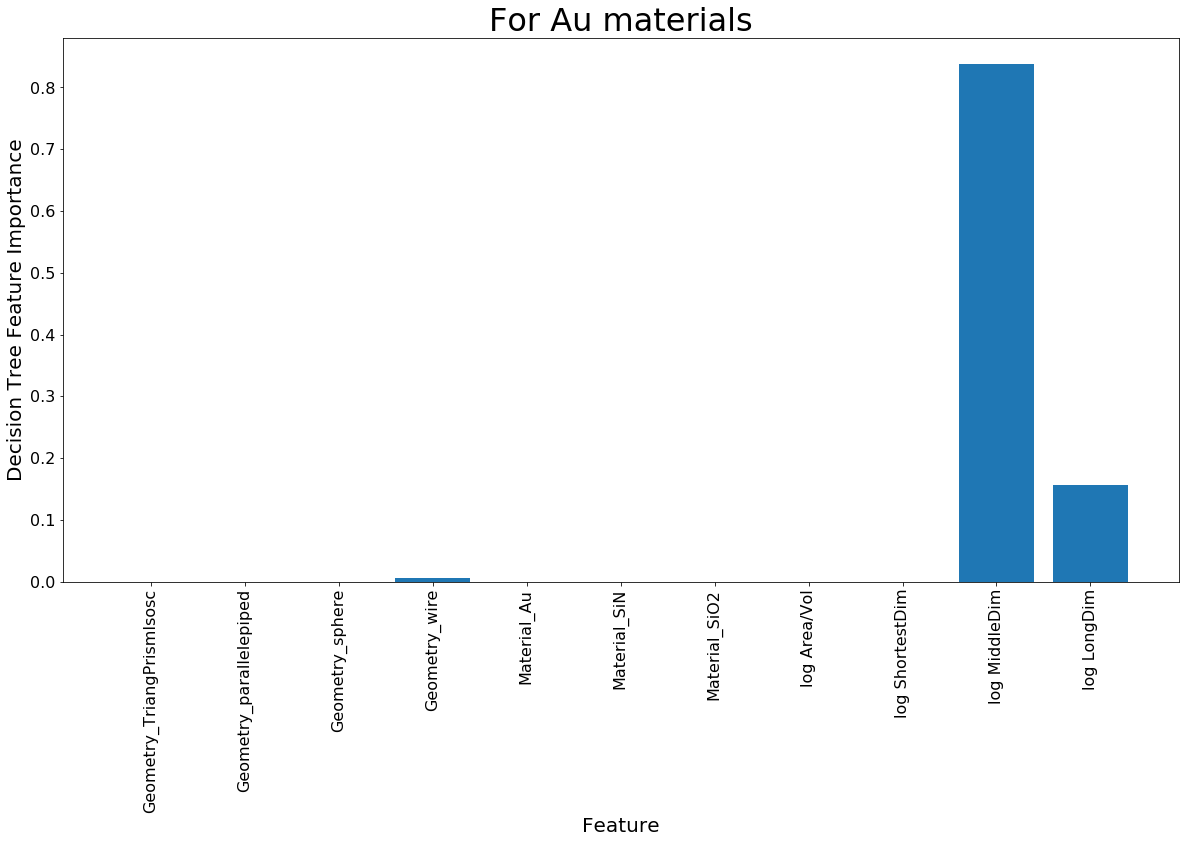

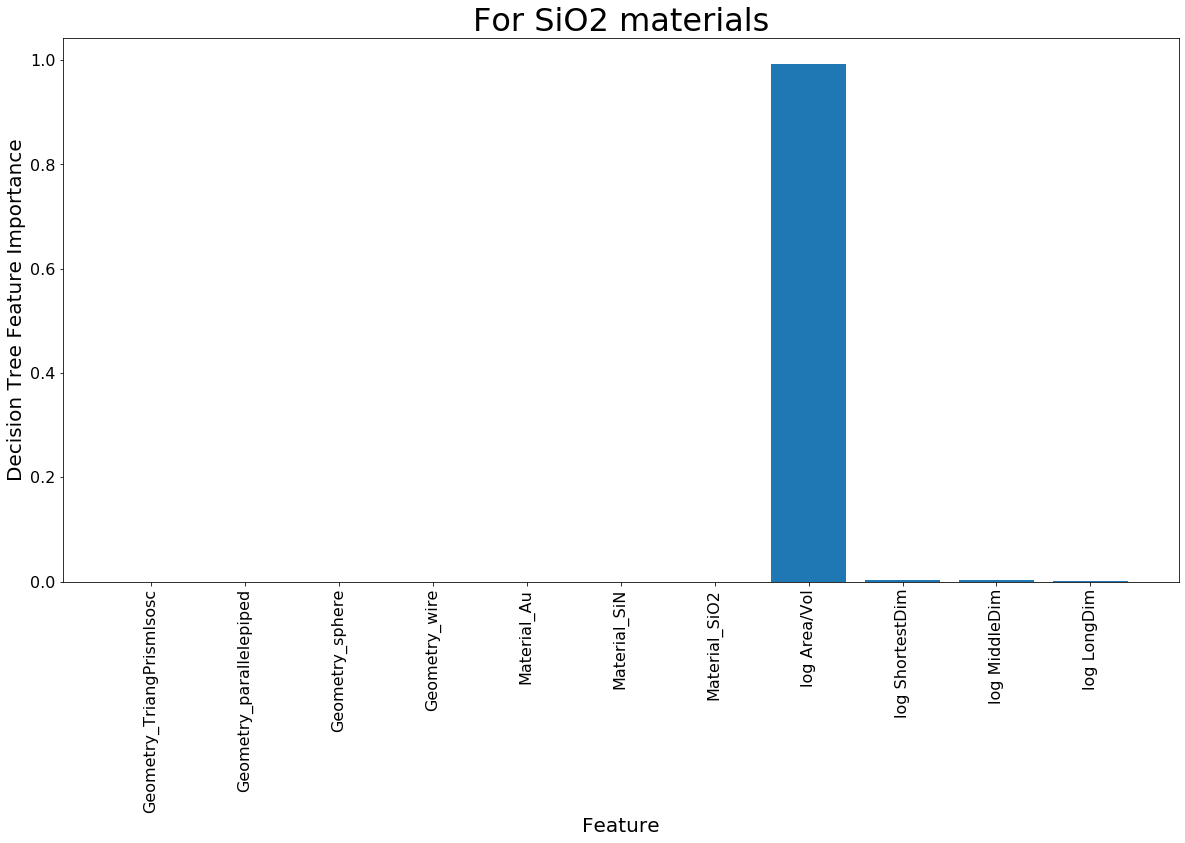

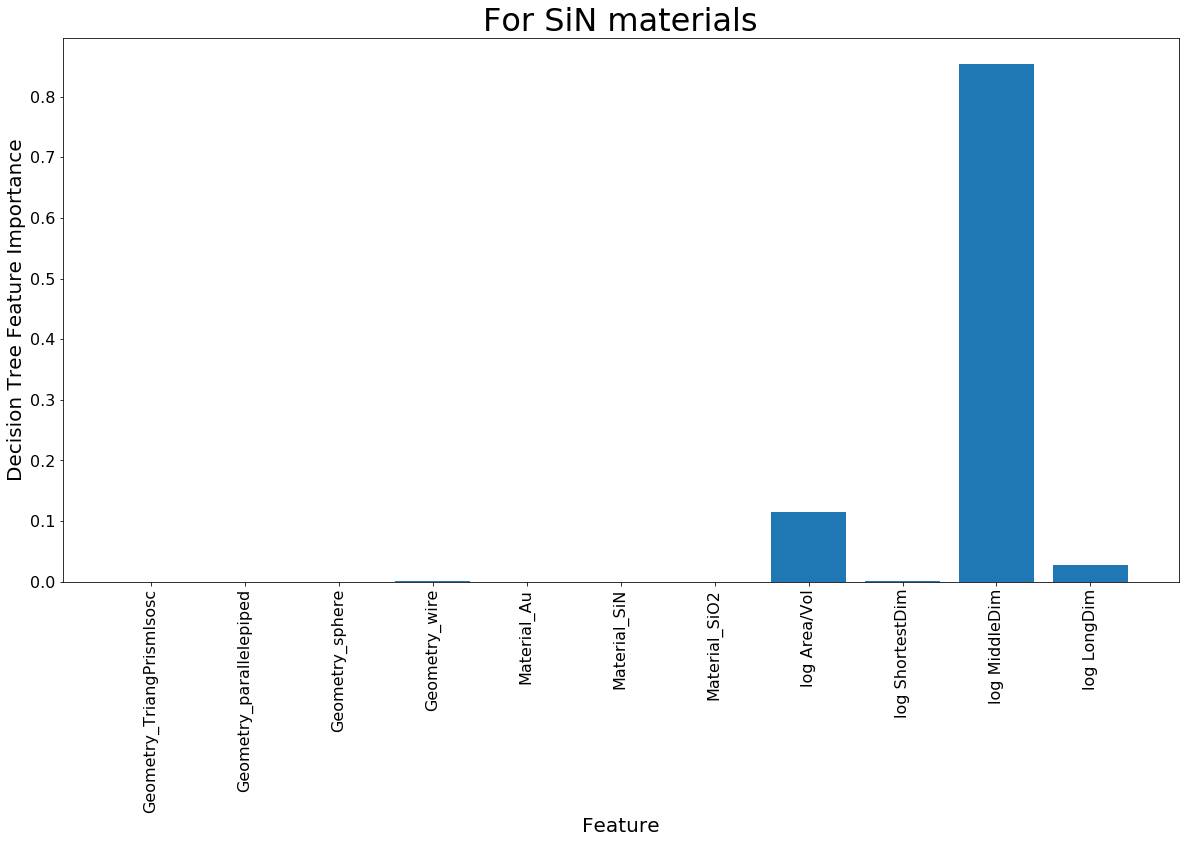

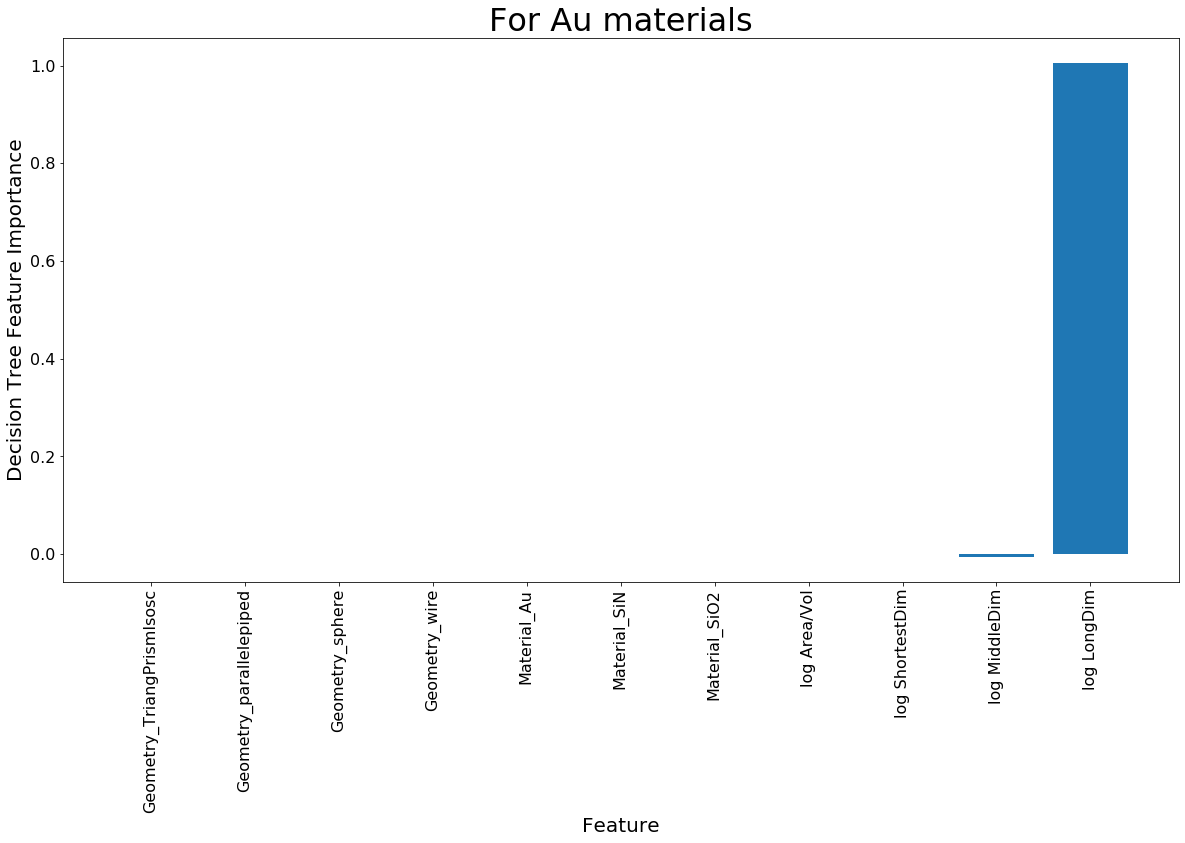

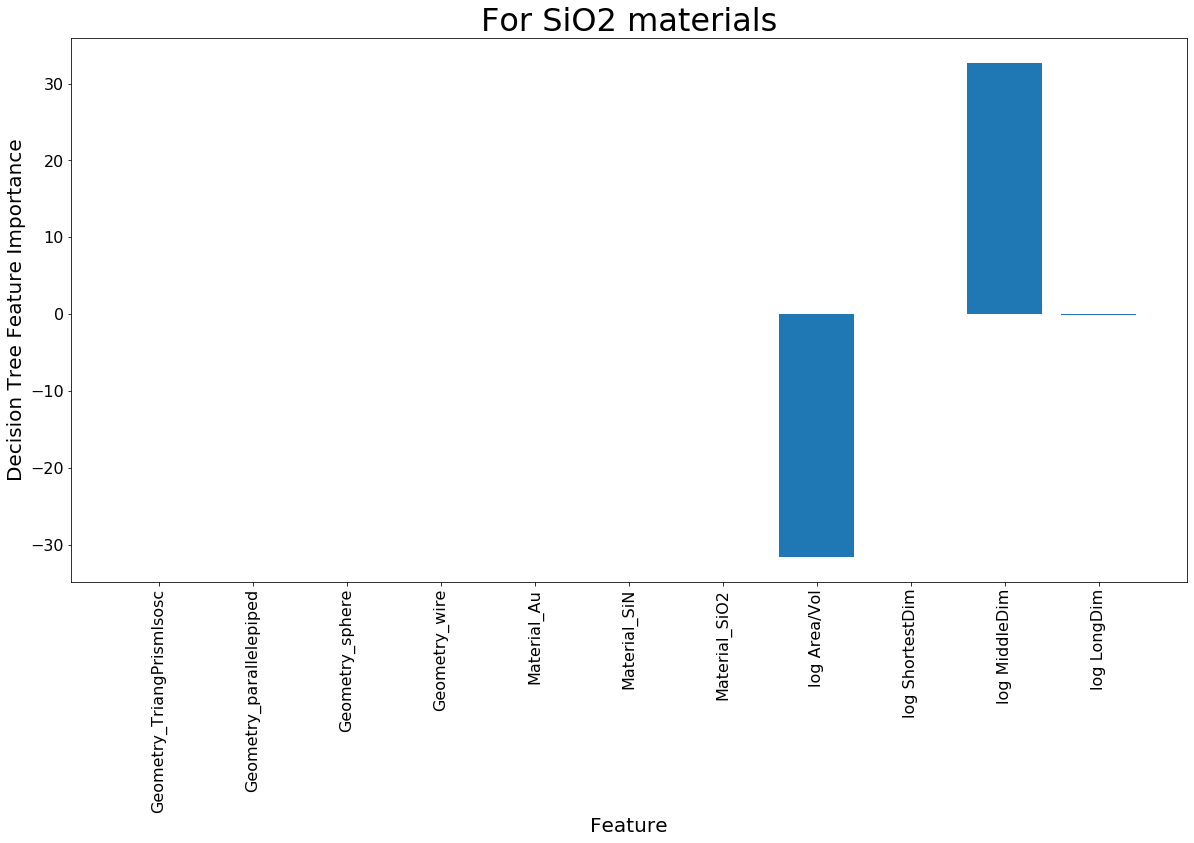

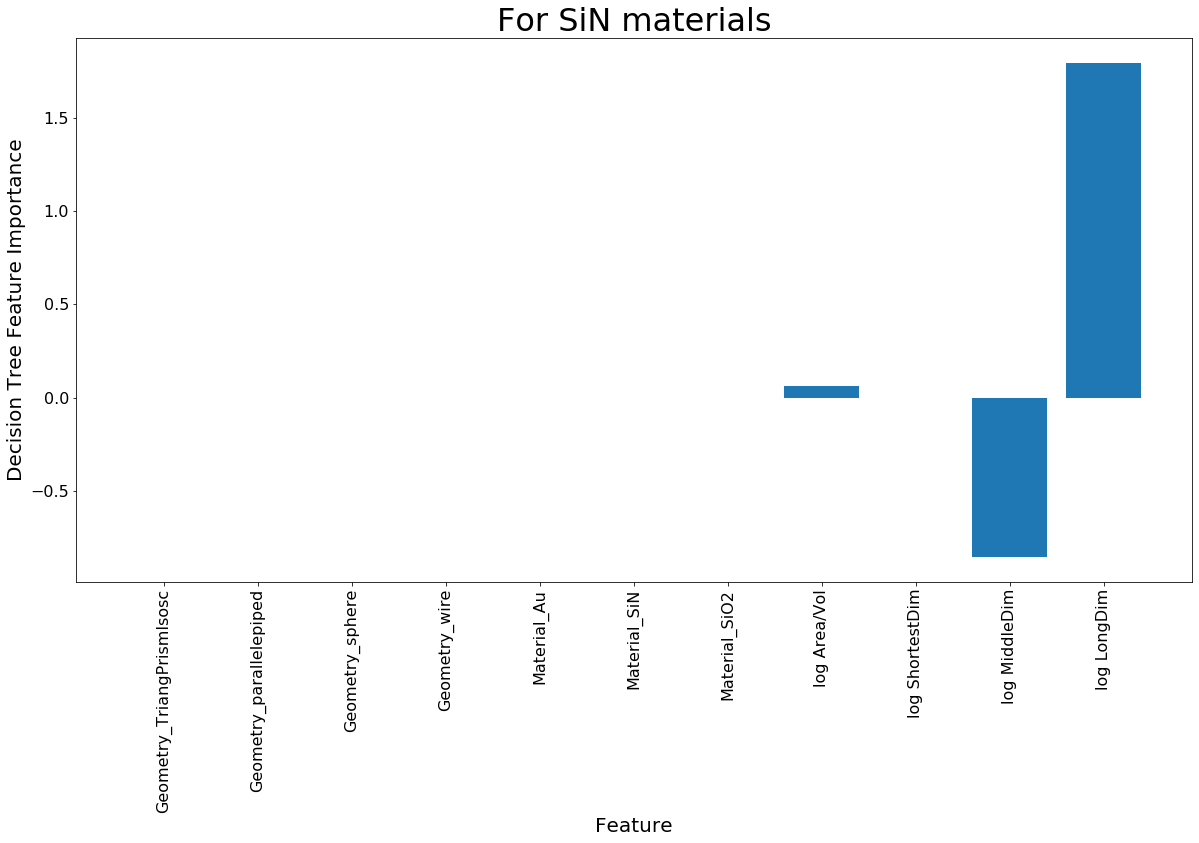

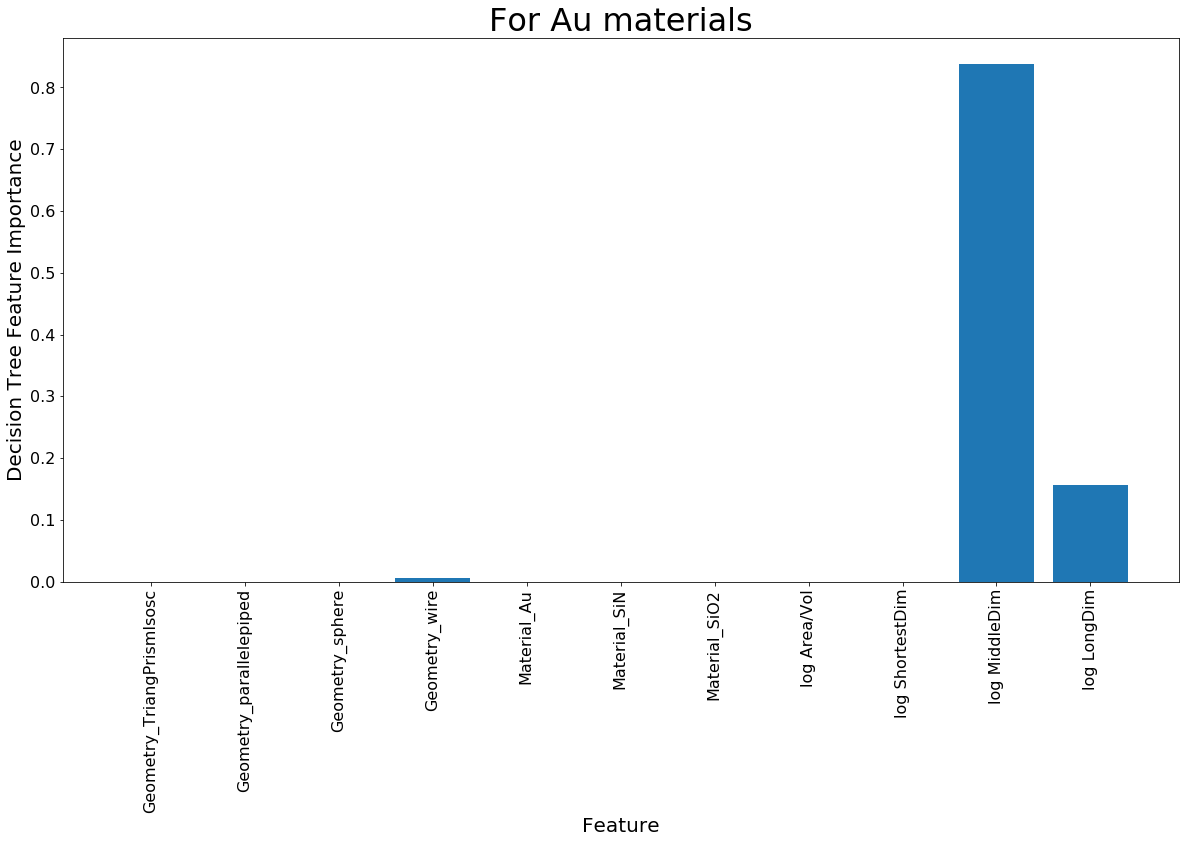

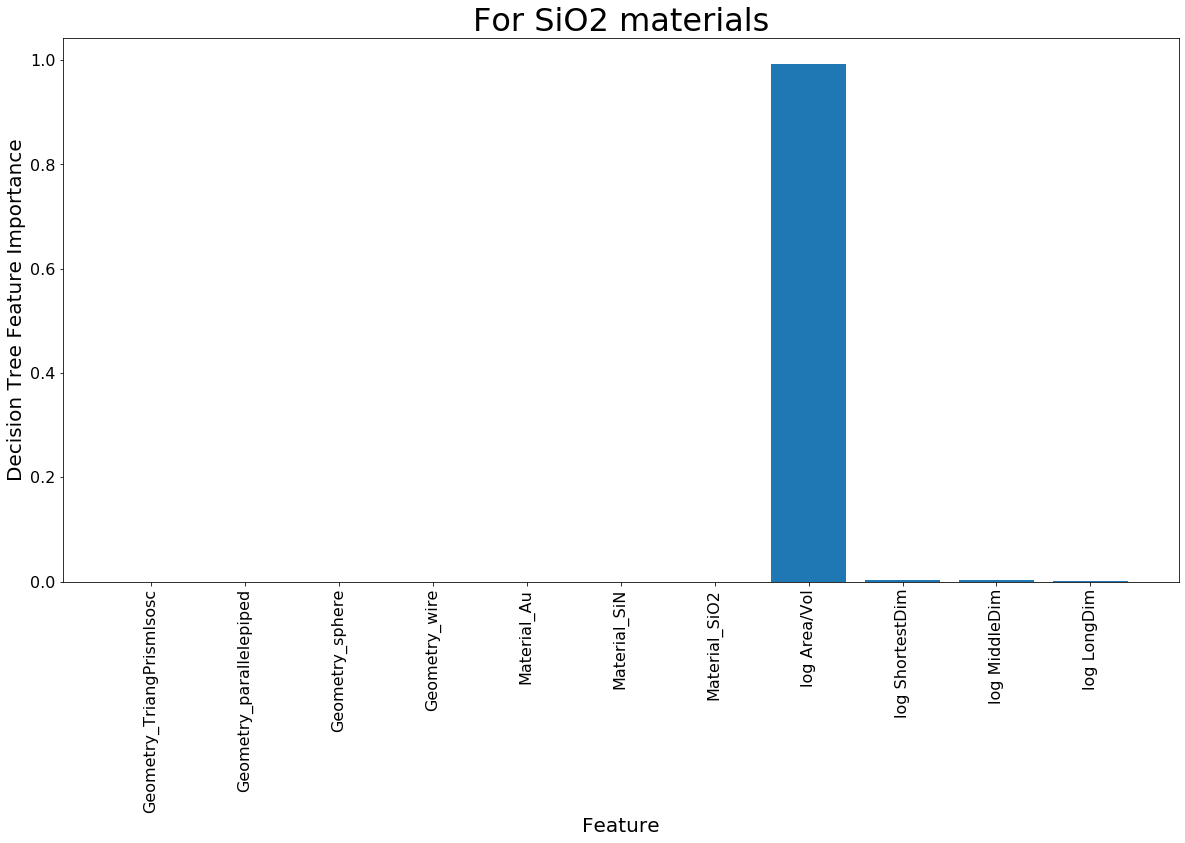

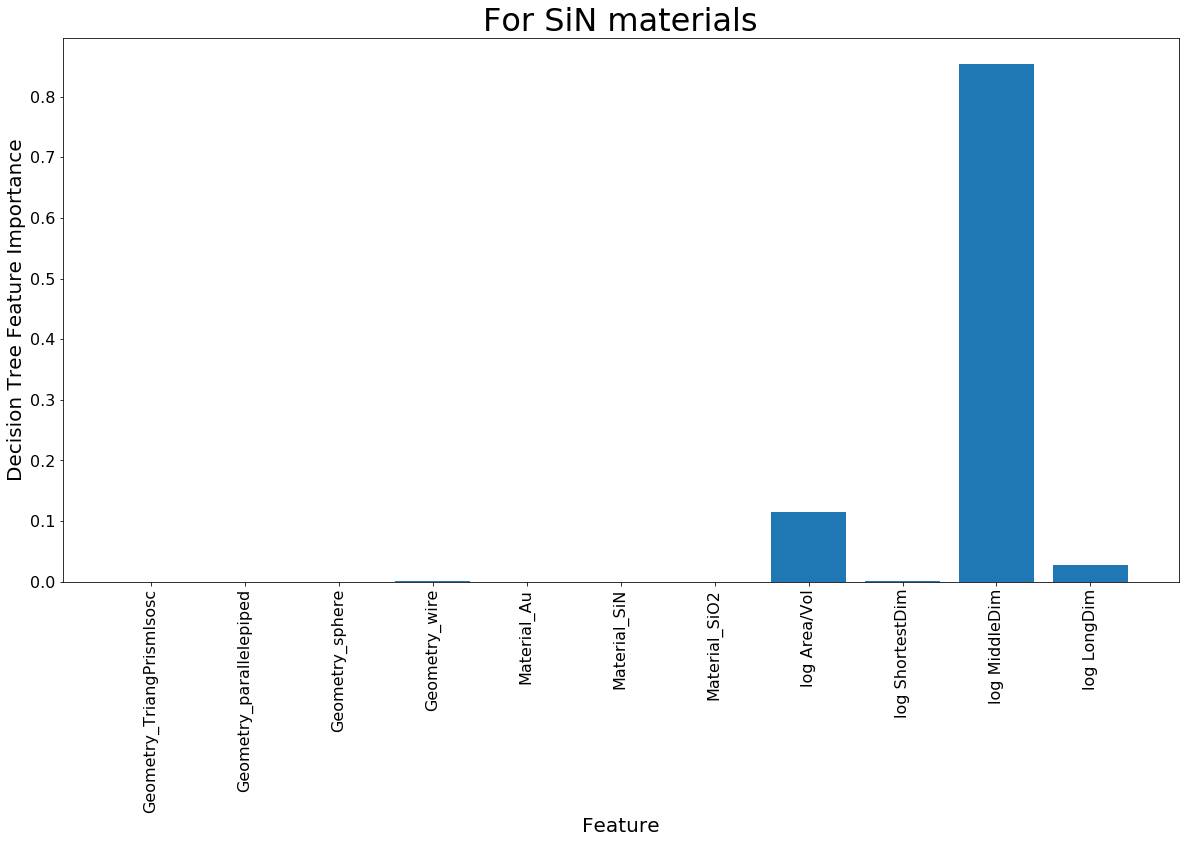

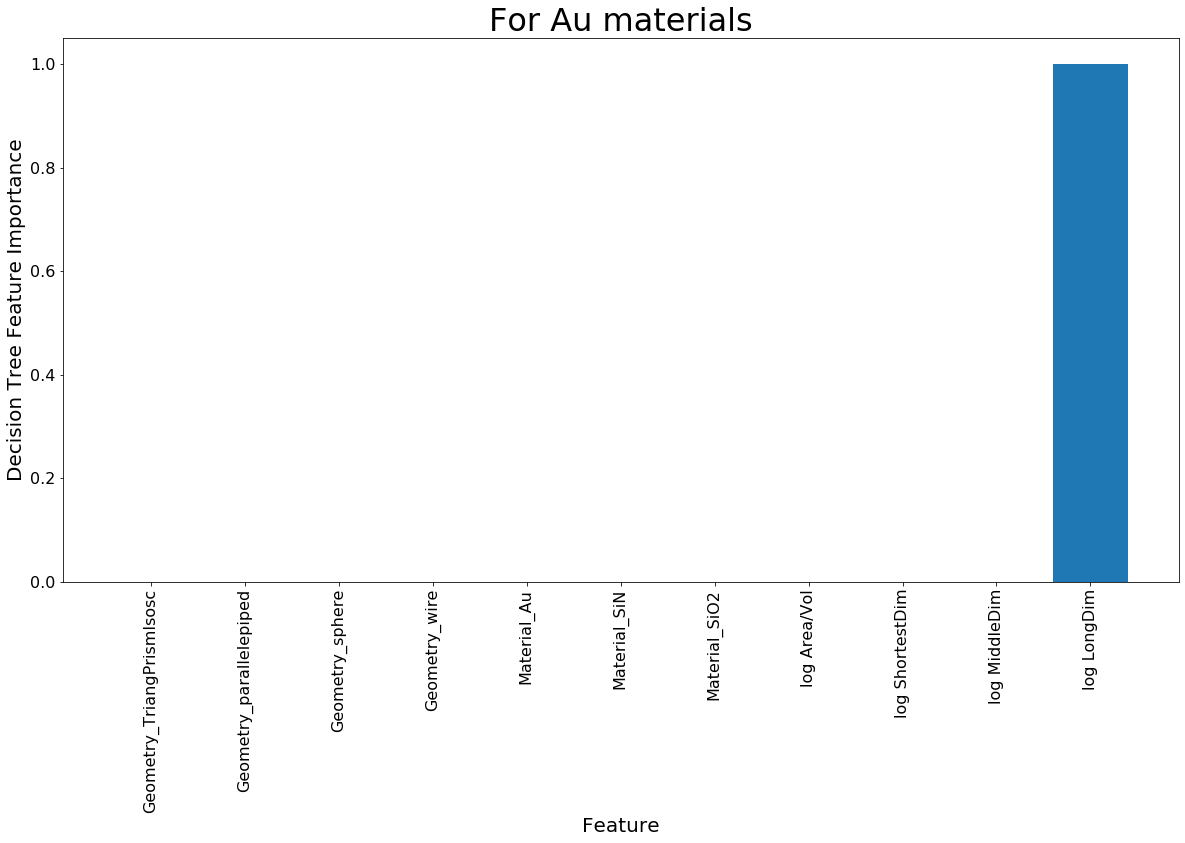

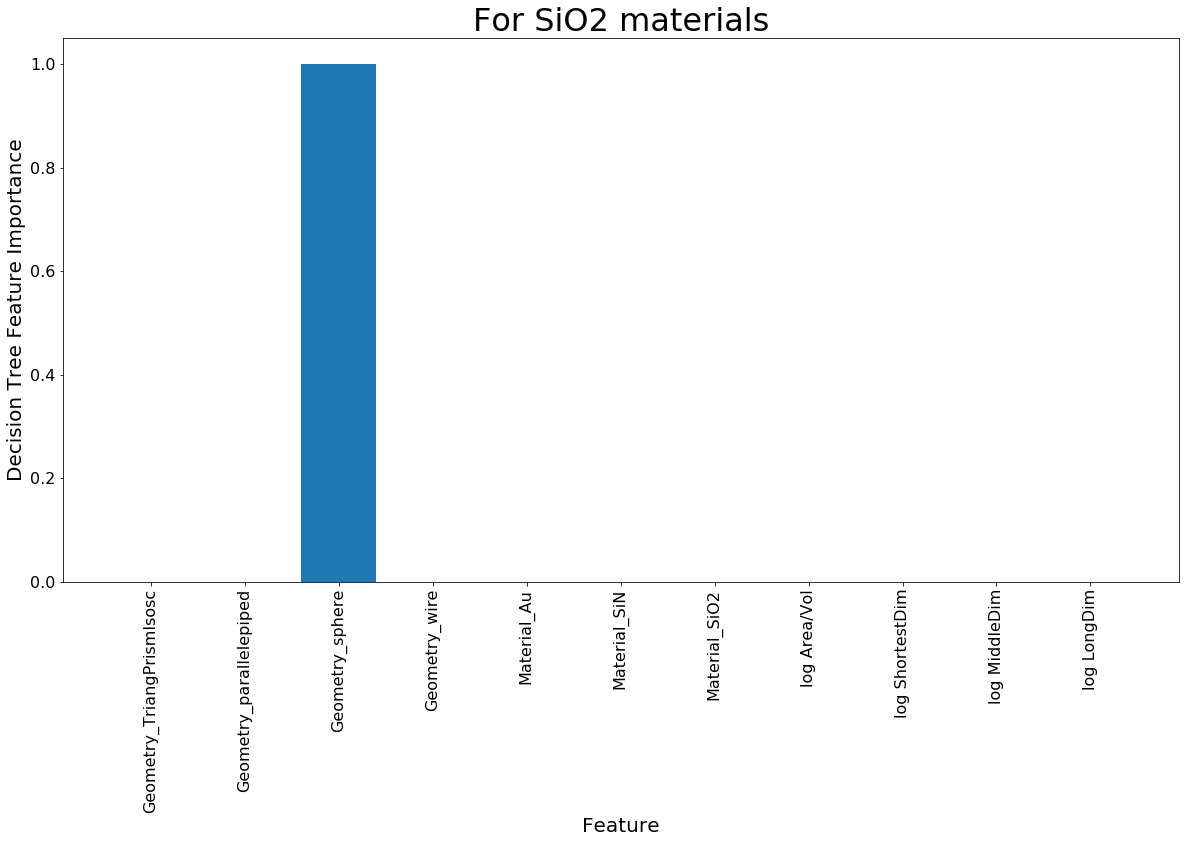

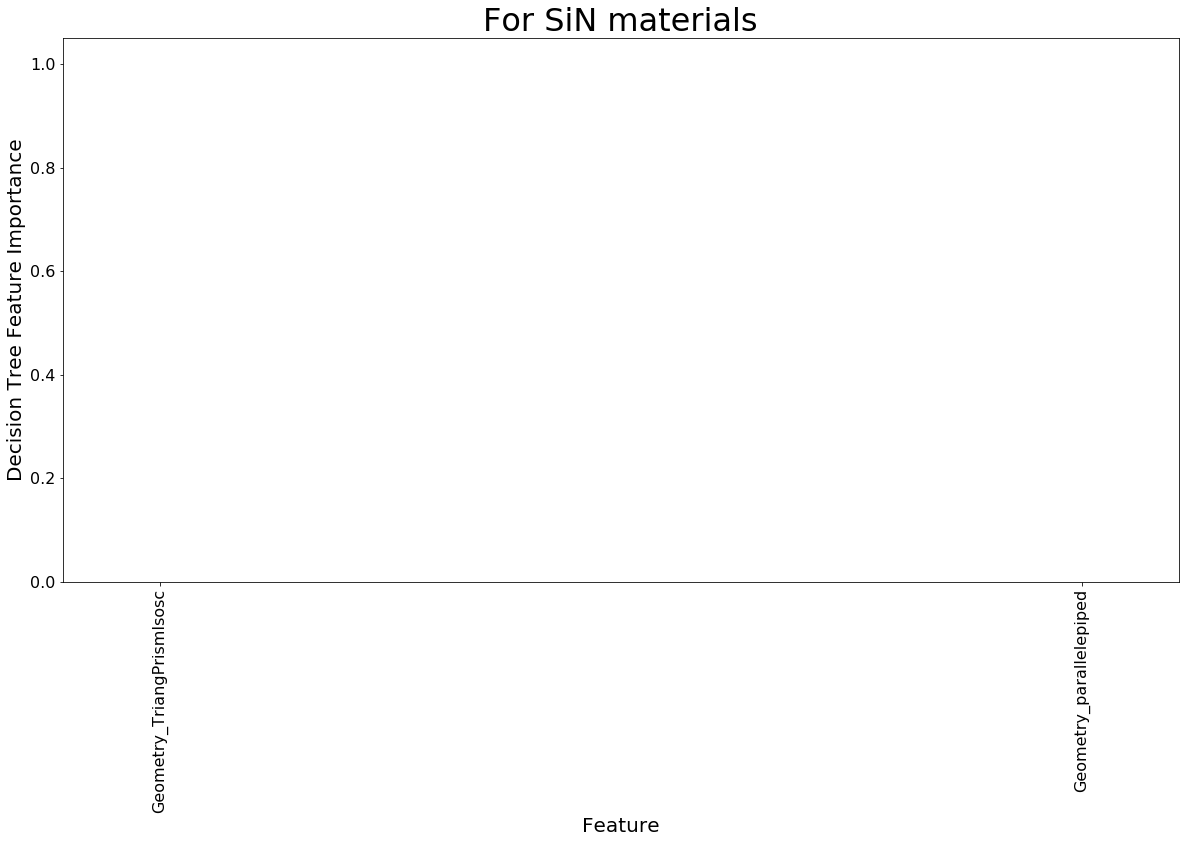

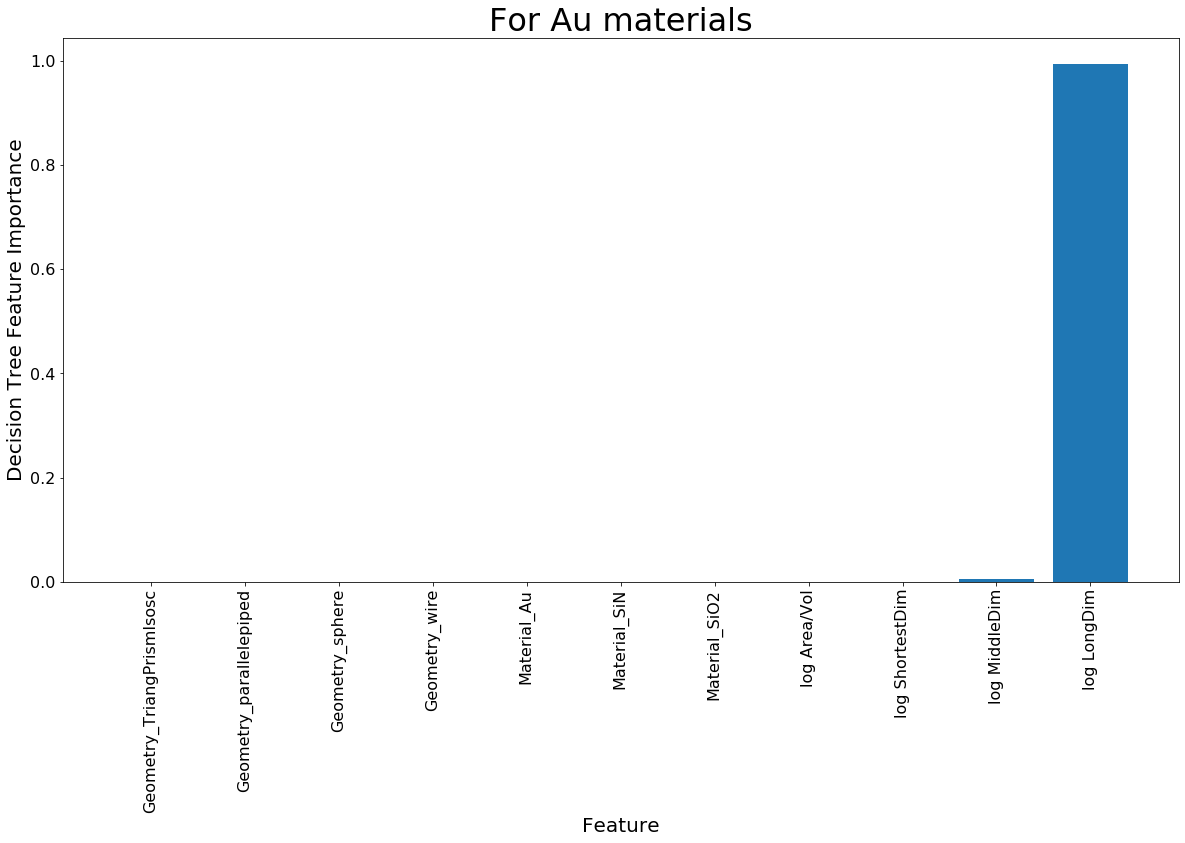

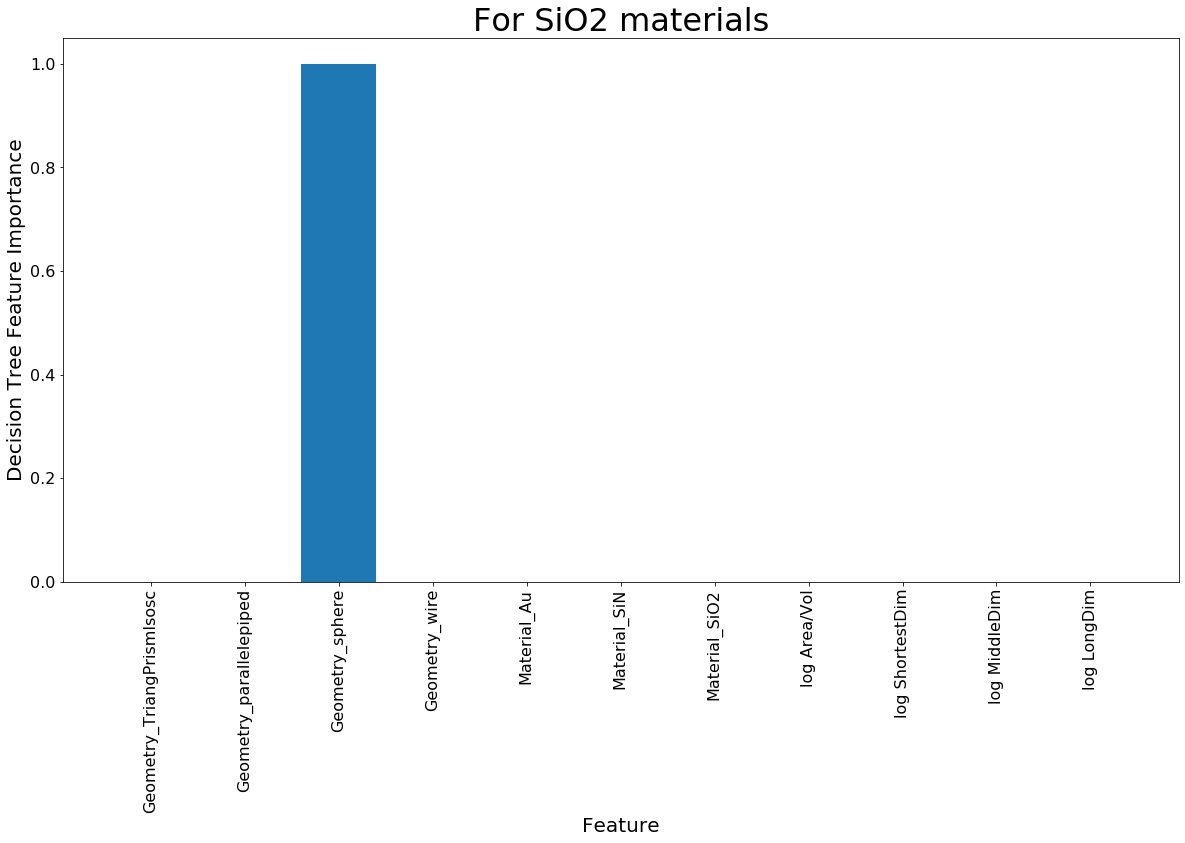

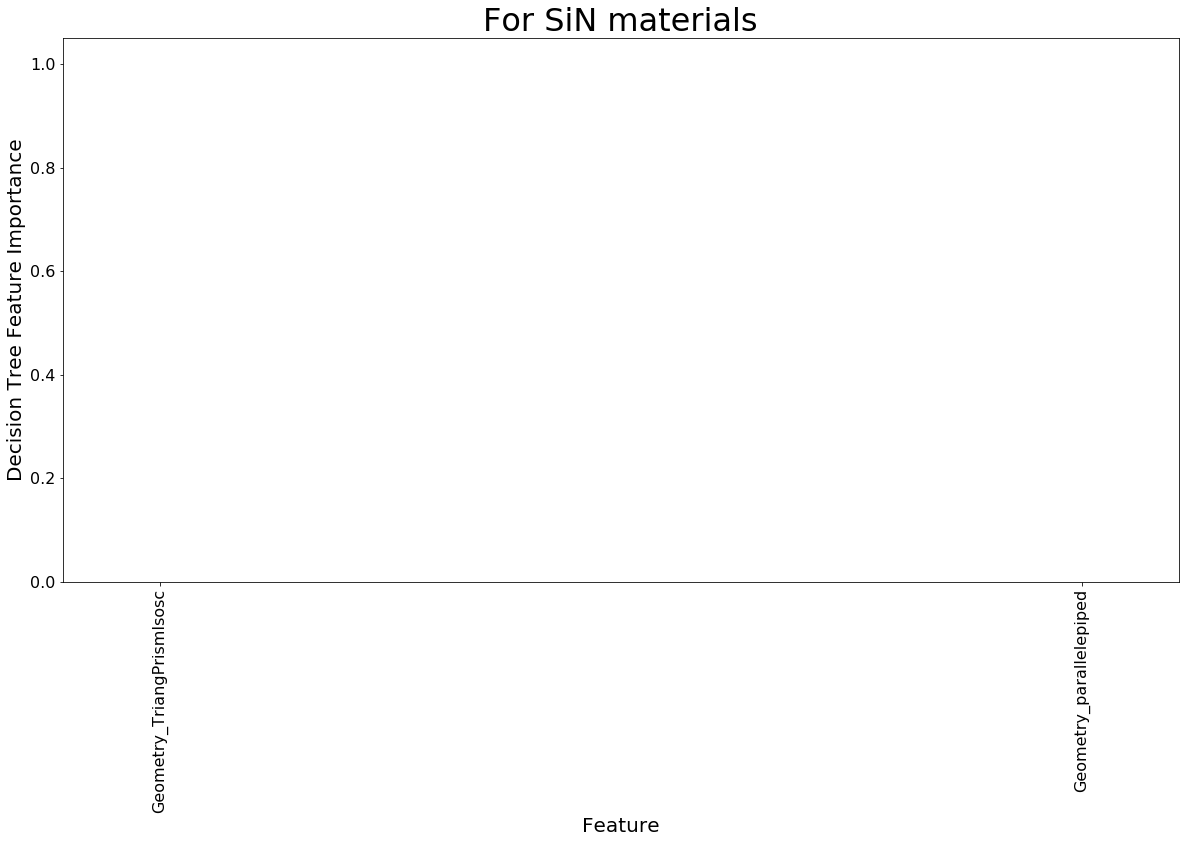

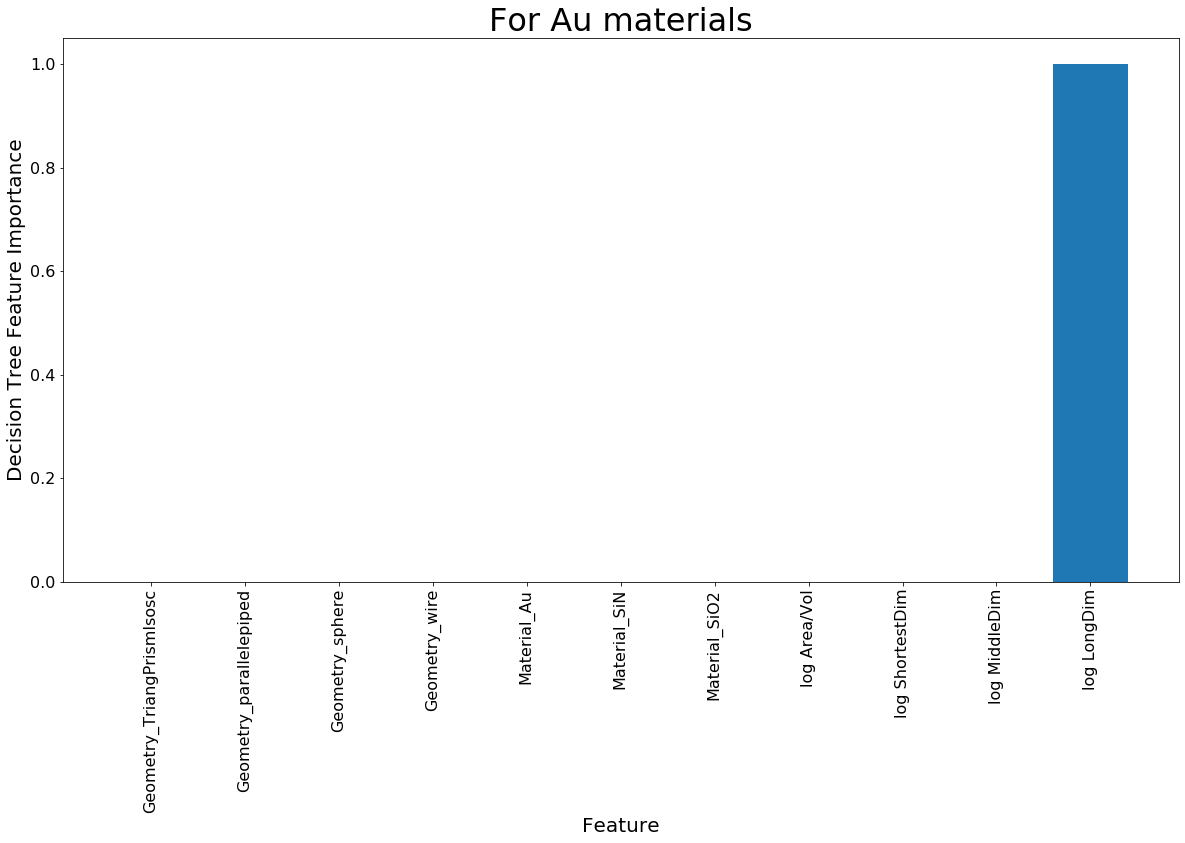

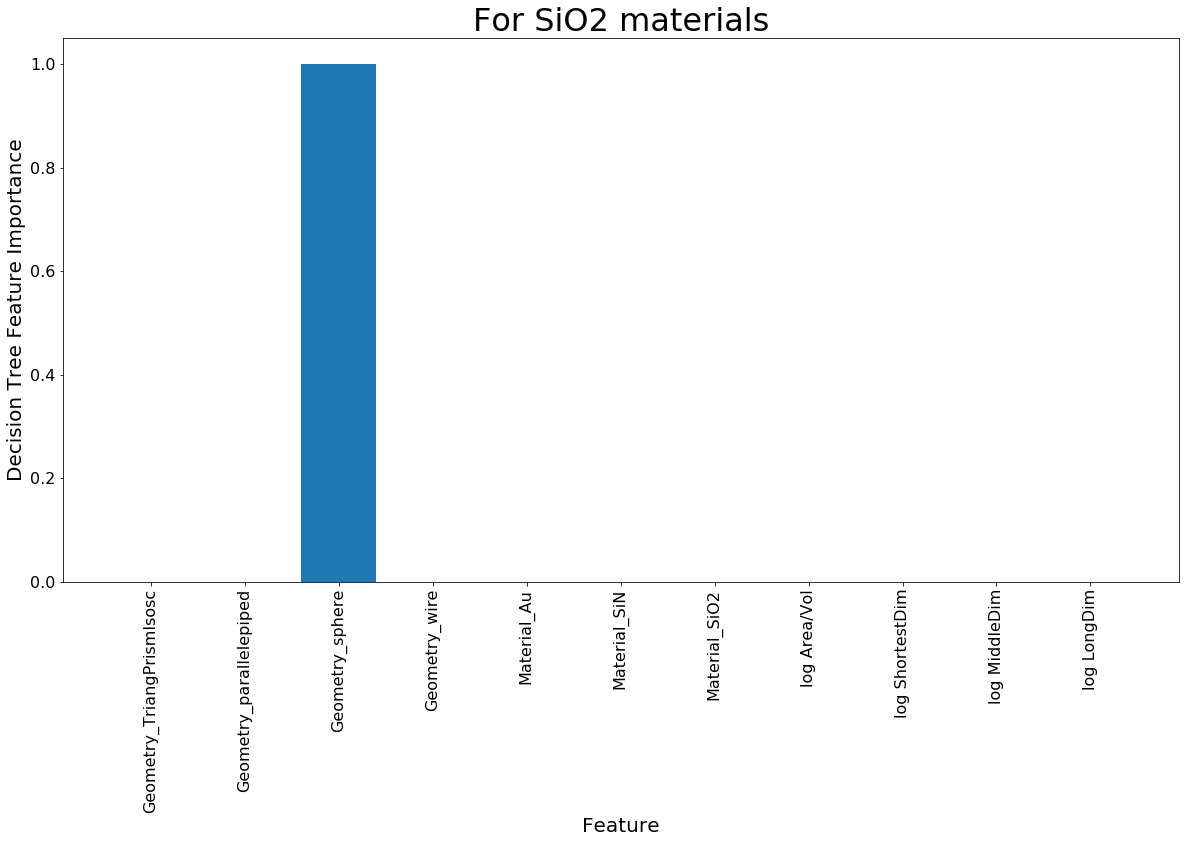

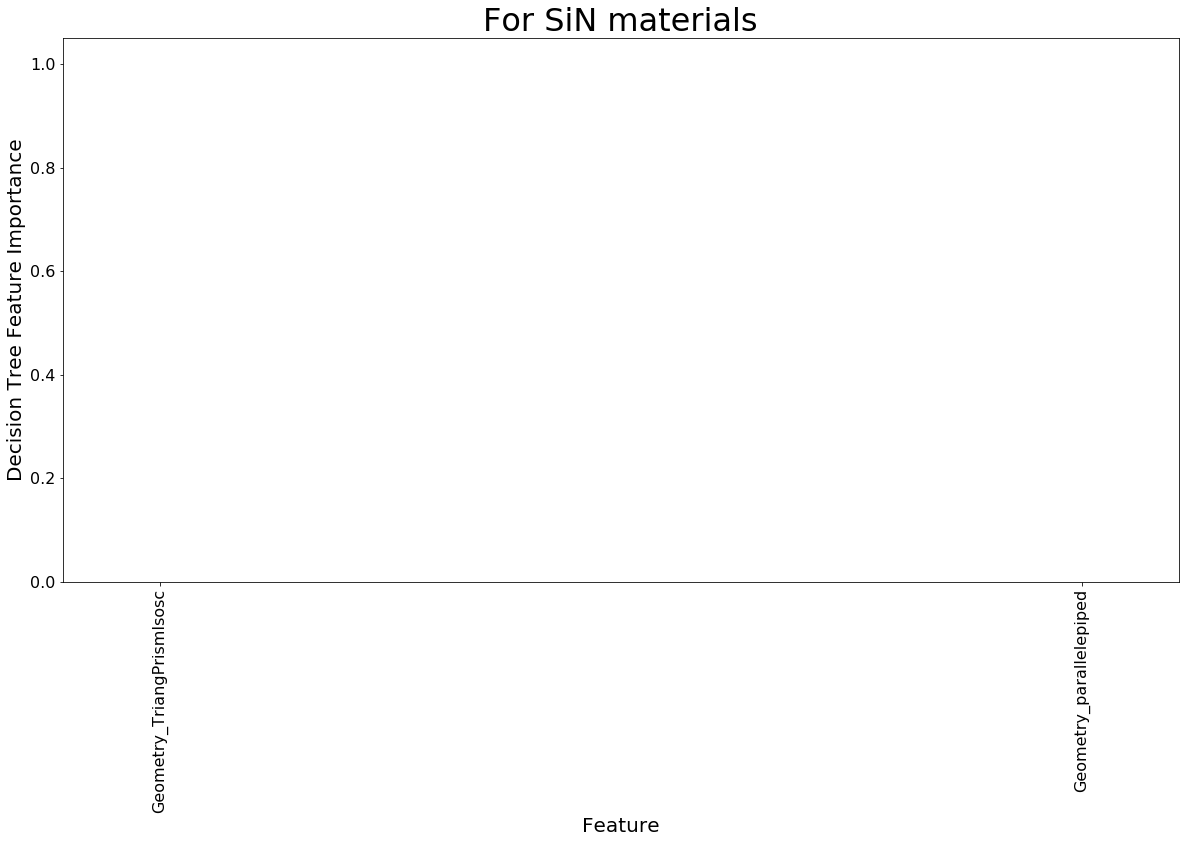

In [5]:
# %% inference RF and DT. Create DTGEN =========================================
time_train = {}
time_pred = {}
for spectral_or_scalar_calc in spectral_or_scalar_calc_all:
    # folder to save the data
    save_folder = '../cache/r{0}_'.format(datetime_str) + \
        optional_title_folders + '/' + spectral_or_scalar_calc + '/'
    os.makedirs(save_folder, exist_ok=True)

    # preparing features and labels
    X = data_featurized[feature_set].copy()
    if spectral_or_scalar_calc == 'spectral':
        y = interpolated_ys
        train_data_size_fraction = train_datasize_fraction_spectral
    elif spectral_or_scalar_calc == 'scalar':
        y = data_featurized['Emissivity'].values
        train_data_size_fraction = train_datasize_fraction_scalar

    # effect of datasize on model performance
    if Study_performance_VS_datasize:
        n_iter = 0
        for data_size_fraction_here in data_size_fraction_:
            for iii in np.arange(num_folds_repeat_DataReduction):
                n_iter = n_iter + 1
                print("using {0} of the data, reducing data for the {1} time".format(
                    data_size_fraction_here, iii))
                print("processing {0} out of {1} iterations ====================================================".format(
                    n_iter, len(data_size_fraction_)*(num_folds_repeat_DataReduction)))

                # here, we will reduce the "training data", not the "entire data"
                test_size_reduced = 1 - data_size_fraction_here
                save_folder_here = save_folder+'frctn_' + \
                    str(data_size_fraction_here)+'/iter_'+str(iii)

                z_RF_DT_DTGEN_error_folds(X[feature_set], y, feature_set, feature_set_dimensions, feature_set_geom_mat, data_featurized, my_x,
                                          num_folds=num_folds_training_for_errors, test_size=test_size_reduced, n_estimators=n_estimators,
                                          n_cpus=n_cpus, keep_spheres=True, optional_title_folders=save_folder_here,
                                          use_log_emissivity=use_log_emissivity, display_plots=False, display_txt_out=True,
                                          RF_or_DT__=Models_to_Study_performanceVSsize, PlotTitle_extra=spectral_or_scalar_calc,
                                          n_gen_to_data_ratio=n_gen_to_data_ratio)

    # to reduce datasize
    test_size = 1-train_data_size_fraction

    # making sure that our X is float
    X = X.astype(np.float64)

    # analysing RF and DT error, if trained multiple times
    for RF_DT__ in ['RF', 'DT']:
        z_RF_DT_DTGEN_error_folds(X, y, feature_set, feature_set_dimensions, feature_set_geom_mat, data_featurized, my_x,
                                  num_folds=num_folds_training_for_errors, test_size=test_size, n_estimators=n_estimators,
                                  n_cpus=n_cpus, keep_spheres=True, optional_title_folders=save_folder,
                                  use_log_emissivity=use_log_emissivity, display_plots=False, display_txt_out=True,
                                  RF_or_DT__=[RF_DT__], PlotTitle_extra=spectral_or_scalar_calc)

    # splitting test and training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=X[feature_set_geom_mat])
    if use_log_emissivity:
        y_train = np.log(y_train)
        # if we have 'ZEROS', its log will be -Inf. We are replacing anything zlose to zero with exp(-25)
        y_train[y_train < -25] = -25

    print("Features used: {0}".format(X.columns))
    print("We have {0} training and {1} test samples here".format(
        len(X_train), len(X_test)))
    n_train = len(X_train)

    # training and testing RF
    print("\nRF inference, {0} =========================================================".format(
        spectral_or_scalar_calc))
    rf = RandomForestRegressor(n_estimators, n_jobs=n_cpus)

    start_time = time()
    rf.fit(X_train, y_train)
    time_train['RF_'+spectral_or_scalar_calc] = time() - start_time

    start_time = time()
    if use_log_emissivity:
        y_pred_rf = np.exp(rf.predict(X_test))
    else:
        y_pred_rf = spectra_prediction_corrector(rf.predict(X_test))
    time_pred['RF_'+spectral_or_scalar_calc] = time() - start_time

    print("RF error analysis")
    rf_r2, rf_mae, rf_mse, rf_Erel, rf_r2_all, rf_mae_all, rf_mse_all, rf_Erel_all = calc_RMSE_MAE_MSE_Erel(
        y_test, y_pred_rf, my_x)

    # training and testing DT
    print("\nDT inference, {0} =========================================================".format(
        spectral_or_scalar_calc))
    dt = DecisionTreeRegressor()

    start_time = time()
    dt.fit(X_train, y_train)
    time_train['DT_'+spectral_or_scalar_calc] = time() - start_time

    start_time = time()
    if use_log_emissivity:
        y_pred_dt = np.exp(dt.predict(X_test))
    else:
        y_pred_dt = spectra_prediction_corrector(dt.predict(X_test))
    time_pred['DT_'+spectral_or_scalar_calc] = time() - start_time

    print("DT error analysis")
    dt_r2, dt_mae, dt_mse, dt_Erel, dt_r2_all, dt_mae_all, dt_mse_all, dt_Erel_all = calc_RMSE_MAE_MSE_Erel(
        y_test, y_pred_dt, my_x)

    # Generating data for DTGEN, training and testing DTGEN
    print("\nDT GEN inference, {0} =====================================================".format(
        spectral_or_scalar_calc))
    X_train_all_columns = data_featurized.loc[X_train.index, :]
    start_time = time()
    n_gen = int(len(X_train_all_columns) * n_gen_to_data_ratio)
    X_gen = gen_data_P1_P2_P3_Elzouka(X_train_all_columns, n_gen)
    X_gen = pd.DataFrame(X_gen, columns=X_train.columns).astype(np.float64)
    X_gen = X_gen[feature_set]
    end_time = time()
    print('done generating input features for DTGEN in {0} seconds'.format(
        end_time-start_time))
    time_DTGEN_feature_creation = end_time - start_time

    # predicting emissivity using RF for the generated data ------------------
    start_time = time()
    if use_log_emissivity:
        y_gen = np.exp(rf.predict(X_gen))
    else:
        y_gen = spectra_prediction_corrector(rf.predict(X_gen))
    end_time = time()
    print('done predicting emissivity using the input features using RF in {0} seconds'.format(
        end_time-start_time))
    time_DTGEN_label_creation = end_time - start_time

    # adding the generated emissivity to original training emissivity ------------------
    if use_log_emissivity:
        X_new_train, y_new_train = pd.concat(
            [X_gen, X_train]), np.concatenate([np.log(y_gen), y_train])
    else:
        X_new_train, y_new_train = pd.concat(
            [X_gen, X_train]), np.concatenate([y_gen, y_train])

    # creating a single decision tree trained on generated and original training emissivity
    new_n_train = n_gen + n_train
    dt_gen = DecisionTreeRegressor(min_samples_leaf=3)

    start_time = time()
    dt_gen.fit(X_new_train, y_new_train)
    time_train['DTGEN_'+spectral_or_scalar_calc] = time() - start_time

    start_time = time()
    if use_log_emissivity:
        y_pred_dtgen = np.exp(dt_gen.predict(X_test))
        y_new_train = np.exp(y_new_train)
        y_train = np.exp(y_train)
    else:
        y_pred_dtgen = dt_gen.predict(X_test)
    time_pred['DTGEN_'+spectral_or_scalar_calc] = time() - start_time

    print("DTGEN error analysis")
    dt_gen_r2, dt_gen_mae, dt_gen_mse, dt_gen_Erel, dt_gen_r2_all, dt_gen_mae_all, dt_gen_mse_all, dt_gen_Erel_all = calc_RMSE_MAE_MSE_Erel(
        y_test, y_pred_dtgen, my_x)

    # %% feature importance ====================================================
    feature_importance_by_material(dt, X_train, y_train)
    feature_importance_by_material(dt_gen, X_train, y_train)

    # dt.feature_importances_
    Au_feature_idx, SiO_feature_idx, SiN_feature_idx = np.where(X_train.columns == 'Material_Au')[0][0], np.where(
        X_train.columns == 'Material_SiO2')[0][0], np.where(X_train.columns == 'Material_SiN')[0][0]

    Au_feature_importances, SiO_feature_importances, SiN_feature_importances = np.zeros(
        dt.n_features_), np.zeros(dt.n_features_), np.zeros(dt.n_features_)
    Au_node_id, SiO_node_id, SiN_node_id = [], [], []

    # get feature importances and all tree parameters
    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold
    impurity = dt.tree_.impurity
    weighted_samples = dt.tree_.weighted_n_node_samples
    n_samples = dt.tree_.n_node_samples
    feature_importances = np.ones(dt.n_features_)

    # if less than threshold, go to left children, if greater than threshold, go to right children
    for i in range(n_nodes):
        this_node_feature = feature[i]
        if this_node_feature == Au_feature_idx:
            if threshold[i] != 0.5:
                assert children_right[i] == children_left[i]  # is leaf
                continue
            else:
                assert threshold[i] == 0.5
                Au_node_id.extend(get_all_children(
                    children_right[i], children_left, children_right))
                Au_node_id.append(children_right[i])

        elif this_node_feature == SiO_feature_idx:
            if threshold[i] != 0.5:
                assert children_right[i] == children_left[i]  # is leaf
                continue
            else:
                assert threshold[i] == 0.5
                SiO_node_id.extend(get_all_children(
                    children_right[i], children_left, children_right))
                SiO_node_id.append(children_right[i])

        elif this_node_feature == SiN_feature_idx:
            if threshold[i] != 0.5:
                assert children_right[i] == children_left[i]  # is leaf
                continue
            else:
                assert threshold[i] == 0.5
                SiN_node_id.extend(get_all_children(
                    children_right[i], children_left, children_right))
                SiN_node_id.append(children_right[i])

        else:
            if not((i in Au_node_id) or (i in SiN_node_id) or (i in SiO_node_id)):
                # Au_node_id.append(i)
                # SiO_node_id.append(i)
                # SiN_node_id.append(i)
                continue  # probably why everything looks the same
            else:
                continue

    # remove duplicate nodes
    Au_node_id = np.unique(Au_node_id)
    SiO_node_id = np.unique(SiO_node_id)
    SiN_node_id = np.unique(SiN_node_id)

    # Get feature importances
    for i in Au_node_id:
        if (feature[i] != SiN_feature_idx) and (feature[i] != SiO_feature_idx):
            Au_feature_importances[feature[i]] += (
                weighted_samples[i] * impurity[i] -
                weighted_samples[children_left[i]] * impurity[children_left[i]] -
                weighted_samples[children_right[i]] * impurity[children_right[i]])
    Au_feature_importances /= weighted_samples[0]
    Au_feature_importances /= np.sum(Au_feature_importances)

    for i in SiO_node_id:
        if (feature[i] != SiN_feature_idx) and (feature[i] != Au_feature_idx):
            SiO_feature_importances[feature[i]] += (
                weighted_samples[i] * impurity[i] -
                weighted_samples[children_left[i]] * impurity[children_left[i]] -
                weighted_samples[children_right[i]] * impurity[children_right[i]])
    SiO_feature_importances /= weighted_samples[0]
    SiO_feature_importances /= np.sum(SiO_feature_importances)

    for i in SiN_node_id:
        if (feature[i] != Au_feature_idx) and (feature[i] != SiO_feature_idx):
            SiN_feature_importances[feature[i]] += (
                weighted_samples[i] * impurity[i] -
                weighted_samples[children_left[i]] * impurity[children_left[i]] -
                weighted_samples[children_right[i]] * impurity[children_right[i]])
    print(SiN_feature_importances)
    SiN_feature_importances /= weighted_samples[0]
    SiN_feature_importances /= np.sum(SiN_feature_importances)

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(X.columns, Au_feature_importances)
    ax.set_ylabel("Decision Tree Feature Importance", fontsize=20)
    ax.set_xlabel("Feature", fontsize=20)
    ax.set_title("For Au materials", fontsize=32)
    ax.xaxis.set_tick_params(labelsize=16, rotation=90)
    ax.yaxis.set_tick_params(labelsize=16)

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(X.columns, SiO_feature_importances)
    ax.set_ylabel("Decision Tree Feature Importance", fontsize=20)
    ax.set_xlabel("Feature", fontsize=20)
    ax.set_title("For SiO2 materials", fontsize=32)
    ax.xaxis.set_tick_params(labelsize=16, rotation=90)
    ax.yaxis.set_tick_params(labelsize=16)

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(X.columns, SiN_feature_importances)
    ax.set_ylabel("Decision Tree Feature Importance", fontsize=20)
    ax.set_xlabel("Feature", fontsize=20)
    ax.set_title("For SiN materials", fontsize=32)
    ax.xaxis.set_tick_params(labelsize=16, rotation=90)
    ax.yaxis.set_tick_params(labelsize=16)

    # %% save ML models, test and train data ===================================
    # Save in Python format
    variable_name_list = ['rf', 'dt', 'dt_gen',
                          'X_train', 'X_new_train', 'X_test',
                          'y_train', 'y_new_train', 'y_test',
                          'n_gen', 'train_data_size_fraction', 'my_x', 'scaling_factors']
    for variable_name in variable_name_list:
        joblib.dump(globals()[variable_name],
                    save_folder+variable_name+'.joblib')

    # Save in MATLAB format
    filename_mat = 'inference_{0}_RF_DT_DTGEN'.format(spectral_or_scalar_calc)
    dict_to_save = {}
    X_test_index_py = np.array(X_test.index)
    X_test_index_mat = X_test_index_py + 1
    X_train_index_py = np.array(X_train.index)
    X_train_index_mat = X_train_index_py+1
    variable_name_list = ['X_train_index_py', 'X_test_index_py', 'X_train_index_mat', 'X_test_index_mat',
                          'y_train', 'y_test', 'my_x', 'scaling_factors', 'time_train', 'time_pred', 'time_DTGEN_feature_creation', 'time_DTGEN_label_creation',
                          'y_pred_rf', 'y_pred_dt', 'y_pred_dtgen',
                          'rf_r2', 'rf_mae', 'rf_mse', 'rf_Erel', 'rf_r2_all', 'rf_mae_all', 'rf_mse_all', 'rf_Erel_all',
                          'dt_r2', 'dt_mae', 'dt_mse', 'dt_Erel', 'dt_r2_all', 'dt_mae_all', 'dt_mse_all', 'dt_Erel_all',
                          'dt_gen_r2', 'dt_gen_mae', 'dt_gen_mse', 'dt_gen_Erel', 'dt_gen_r2_all', 'dt_gen_mae_all', 'dt_gen_mse_all', 'dt_gen_Erel_all',
                          'matlab_data_path', 'feature_set']
    for variable_name in variable_name_list:
        dict_to_save[variable_name] = globals()[variable_name]
    scipy.io.savemat(save_folder+filename_mat+'.mat', dict_to_save)

# Step #6: The inverse problem

In [11]:
#%% Inputs
date_for_dirname = 'd_'+strftime("%Y%m%d_%H%M%S") + '_'

use_log_emissivity = True
DT_or_DTGEN__ = ['DT', 'DTGEN'] #DT_or_DTGEN__ = ['DT'] #

gen_n = 2500 # number of posible InverseDesign features suggested by ML model

InverseDesign_scalar = False
target_scalar_emissivity_ = [0.1, 0.5]

InverseDesign_spectral = True

RadCooling = False

ChooseRandomFromTest_eachMat = True;

IndexTest_targets = True
idx_Test_targets = [5694] # index in Test that we need to target for the inverse design

random_multipeak = False

peak_at_lambda = False
target_peak_center_um = 7.5
target_peak_width_rads = 6e13

feature_importance_permutation = False
sclar_or_spectral = 'scalar'


bestdesign_method =  'absolute_best' #'MorethanOneMatGeom' #

InverseDesignModels_folder = 'latest' # here, input the string 'latest' to use the latest models, or input the folder of the latest model relative to the current folder
#InverseDesignModels_folder = '../cache/results_20191029_174223_smi_final/'
#InverseDesignModels_folder = '../cache/r20191103_145953_20.0sc_20.0sp/'
#InverseDesignModels_folder = '../cache/r20191106_173403_50.0sc_50.0sp/'
#InverseDesignModels_folder = '../cache/r20191112_103049_50.0sc_50.0sp/'

#in case we need to display design rules for a number of leaves. If we really need a neat inverse design, set this to -1
n_best_leaves_force=10


# defining the InverseDesign folder
if InverseDesignModels_folder == 'latest':
    all_subdirs = ['../cache/'+d for d in os.listdir('../cache/') if os.path.isdir('../cache/'+d)]
    InverseDesignModels_folder = max(all_subdirs, key=os.path.getmtime)

   

# Step #6.1: The inverse design for scalar emissivity

In [7]:
#%% load ML models for the inverse design
# this is the folder that contains all the variables
InverseDesignModels_folder_here = InverseDesignModels_folder+'/scalar/'
dirpath_old = os.getcwd()
os.chdir(InverseDesignModels_folder_here)
print("Loading the following variables:")
for filename in glob.glob("*.joblib"):
    variable_name = filename.replace(".joblib",''); # print(filename); 
    print(variable_name)
    globals()[variable_name] = joblib.load(filename)
os.chdir(dirpath_old)    

InverseDesigns_save_folder = InverseDesignModels_folder_here + '/InvDesRes/'
os.makedirs(InverseDesigns_save_folder, exist_ok=True)
InverseDesigns_save_filename = InverseDesigns_save_folder+date_for_dirname

#%% run the inverse design
for DT_or_DTGEN in DT_or_DTGEN__:
    if DT_or_DTGEN == 'DTGEN':            
        estimator_here = dt_gen            
        X_train_here = X_new_train
        y_train_here = y_new_train
    elif DT_or_DTGEN == 'DT':            
        estimator_here = dt            
        X_train_here = X_train
        y_train_here = y_train
    else:
        estimator_here = []

    feature_names = X_train_here.columns
    feature_set_mat = [x for x in feature_names if "Material" in x]
    feature_set_geom = [x for x in feature_names if "Geometry" in x]        
    
    # Do the inverse design for each geometry
    for target_scalar_emissivity in target_scalar_emissivity_:        
        for mat in feature_set_mat:        
            idx_mat = X_train_here[mat].astype(bool) 
            
            InverDesignSaveFilename_CSV = InverseDesigns_save_filename+DT_or_DTGEN+'_'+bestdesign_method+'_'+mat+'_emiss_{0}'.format(target_scalar_emissivity)
            features_InverseDesign_here,min_max_dict,min_max_dict_orig = DoInverseDesign_SaveCSV(estimator_here,X_train_here[idx_mat],y_train_here[idx_mat],target_scalar_emissivity, scaling_factors, gen_n=gen_n, plotting=True, search_method = 'scalar_target', frequency=my_x, n_best_candidates = 3, bestdesign_method=bestdesign_method, InverDesignSaveFilename_CSV = InverDesignSaveFilename_CSV, n_best_leaves_force=n_best_leaves_force)
            features_InverseDesign_here = features_InverseDesign_here.astype(np.float)                                
            

of range nan, [1.446, 1.62]
Out of 1851 samples, 0 passed physicality bounds check
I am tracking back the 7th best leaf
Initial limits, based on the training data range:
log ShortestDim Initial Range: [-3.3312300024539825, 2.5617184391126986]
log MiddleDim Initial Range: [-3.041917772411689, 2.6793754875589224]
log LongDim Initial Range: [-3.041917772411689, 4.7099962832483016]
'log Area/Vol' Initial Range: [-0.8237276463486769, 5.361211460815016]
Area/Vol Initial Range: [  0.43879294 212.98281055]

Rules used to predict sample 9344: 
node_index is: [    0 16792 20144 20145 20146 20147 20148 20154 20155 20156 20157 20165
 20166 20186]
leave_id is: [20186]
this is the winning: Material -------------------------------------------------
decision id node 0 : (X_test[9344, Material_Au] (= 1.0) > 0.5)
decision id node 16792 : (X_test[9344, log LongDim] (= 2.860399572988806) > 0.8326726257801056)
decision id node 20144 : (X_test[9344, log MiddleDim] (= -2.71103307232014) <= -0.673185646533966

In [8]:
dt_gen

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [9]:
feature_names

Index(['Geometry_TriangPrismIsosc', 'Geometry_parallelepiped',
       'Geometry_sphere', 'Geometry_wire', 'Material_Au', 'Material_SiN',
       'Material_SiO2', 'log Area/Vol', 'log ShortestDim', 'log MiddleDim',
       'log LongDim'],
      dtype='object')

In [10]:
target_scalar_emissivity_

[0.1, 0.5, 2, 5]